In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import h5py
import pickle
from tqdm.notebook import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.data.file_utils import GetTV
from src.models import predict #model

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.saving import load_model
from tensorflow.keras.callbacks import EarlyStopping

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [12]:
flatten = lambda x : x.reshape(len(x), -1)

def nearest_index(array, value):
    """Find the index of the nearest value in an array."""
    return (np.abs(array - value)).argmin()

def get_index(arr, coord):
    # Get the insertion indices
    ind = np.searchsorted(coord, arr)

    # Correct the indices to point to the nearest actual index
    ind = np.clip(ind, 0, len(coord) - 1)

    # Now, adjust the indices to get the closest value
    for i, cval in enumerate(arr):
        if ind[i] > 0 and abs(cval - coord[ind[i] - 1]) < abs(cval - coord[ind[i]]):
            ind[i] -= 1
            
    return ind

def reduce_res_2darr(arr, num):
    """Reduce a 2D array by averaging over blocks of size num."""
    return arr[:, ::num, ::num]

In [13]:
models = predict.list_models()
for idx, model in enumerate(models):
    print(idx, model)

0 ../models/weighted_outer_allold_set.pkl
1 ../models/lr_tv_inv_outer.pkl
2 ../models/weighted_outer_all.pkl
3 ../models/weighted_outer_allnew_half_set.pkl
4 ../models/lr_inversion_manual.pkl
5 ../models/lr.pkl
6 ../models/lr_supervised_mdl.pkl


# Data Prep

In [14]:
run_type = 'all'
prep_filename = 'weighted_outer_dataset_' + run_type
prediction_filename = 'weighted_outer_' + run_type
algorithm = 'linear'
split_ratio = 0.2

In [15]:
tv_path = Path('../data/raw/tv_images') / run_type
label_path = Path('../data/labels/weighted_emission') / run_type
prep_path = Path('../data/processed/hdf5')
model_path = Path('../models')

In [16]:
tv = GetTV(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

In [18]:
ml_id = ''
file_name = prep_filename + '.h5'

### Fill Out TV Image Data

In [8]:
def file_split_compile_prep(split_ratio,
                      prep_path,
                      prep_filename,
                      label_path,
                      files):
    # split by file
    train_files, test_files = train_test_split(files, test_size=split_ratio, random_state=182)
    train_files = files
    [print(file.stem) for file in train_files]
    print('-------------------')
    [print(file.stem) for file in test_files]

    points_train = []
    tv_train = []
    points_test = []
    tv_test = []

    for _, file in enumerate(train_files):
        frames = tv.load(file, 'frames').astype('int')
        tv_image = tv.load(file, 'vid')[frames]
        tv_image = reduce_res_2darr(tv_image, 3)
        
        test_label_file = (label_path / file.stem).with_suffix('.pkl')
        with open(test_label_file, 'rb') as f:
            labels = pickle.load(f)
            
        for i in range(len(frames)):
            tv_train.append(tv_image[i])
            points_train.append(labels[i])
            
    for _, file in enumerate(test_files):
        frames = tv.load(file, 'frames').astype('int')
        tv_image = tv.load(file, 'vid')[frames]
        tv_image = reduce_res_2darr(tv_image, 3)
        
        test_label_file = (label_path / file.stem).with_suffix('.pkl')
        with open(test_label_file, 'rb') as f:
            labels = pickle.load(f)
            
        for i in range(len(frames)):
            tv_test.append(tv_image[i])
            points_test.append(labels[i])
            
    with h5py.File(prep_path / str(prep_filename + '.h5'), 'w') as f:
        f.create_dataset('vid_train', data=tv_train)
        f.create_dataset('points_train', data=points_train)
        f.create_dataset('vid_test', data=tv_test)
        f.create_dataset('points_test', data=points_test)
    print(str(prep_path / str(prep_filename + '.h5')),'has been saved!')

In [9]:
file_split_compile_prep(split_ratio, prep_path, prep_filename, label_path, files)

emission_structure_pu_cam240perp_189057
emission_structure_pu_cam240perp_189061
emission_structure_pu_cam240perp_189062
emission_structure_pu_cam240perp_189081
emission_structure_pu_cam240perp_189088
emission_structure_pu_cam240perp_189090
emission_structure_pu_cam240perp_189093
emission_structure_pu_cam240perp_189094
emission_structure_pu_cam240perp_189097
emission_structure_pu_cam240perp_189100
emission_structure_pu_cam240perp_189101
emission_structure_pu_cam240perp_189448
emission_structure_pu_cam240perp_189451
emission_structure_pu_cam240perp_190109
emission_structure_pu_cam240perp_190110
emission_structure_pu_cam240perp_190113
emission_structure_pu_cam240perp_190114
emission_structure_pu_cam240perp_190115
emission_structure_pu_cam240perp_190116
emission_structure_pu_cam240perp_199166
emission_structure_pu_cam240perp_199171
emission_structure_pu_cam240perp_199172
emission_structure_pu_cam240perp_199351
emission_structure_pu_cam240perp_199352
emission_structure_pu_cam240perp_199353


# Train Test Deploy

## Linear Regression

### Train

In [69]:
file_name = prep_filename + '.h5'

with h5py.File(prep_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]
    points_train = f['points_train'][:]
    vid_test = f['vid_test'][:]
    points_test = f['points_test'][:]

files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]
vid_shape = tv.load(files[0], 'vid')[0].shape

In [70]:
X_train = flatten(vid_train)
X_test = flatten(vid_test)
y_train = points_train # flatten(points_train)
y_test = points_test # flatten(points_test)

In [71]:
mdl = LinearRegression()
mdl.fit(X_train, y_train)

LinearRegression()

### Test

In [72]:
# mdl = pickle.load(open('../models/weighted_outer_allold_set.pkl', 'rb'))
r_predict = mdl.predict(X_test)
# real_predict = np.array([radii[np.round(r_predict[:,0]).astype(int)],elevation[np.round(r_predict[:,1]).astype(int)]]).T * 100 # from meter to cm (dimension is n x 2)
# real_y = np.array([radii[np.round(y_test[:,0]).astype(int)],elevation[np.round(y_test[:,1]).astype(int)]]).T * 100
err = mean_absolute_error(r_predict,y_test) * 100
print(err)
# z_err = np.abs(real_predict[:,1] - real_y[:,1])
# print(f"RMS (cm) : {np.sqrt(np.square(dist).mean())}")
# print(f"Z RMS (cm) : {np.sqrt(np.square(z_err).mean())}")

7.900937986032498


In [73]:
print(np.sqrt(mean_squared_error(r_predict,y_test))*100)

11.0915888712356


### Deploy

old_set = before FY2024

In [36]:
ml_id = ''

In [37]:
pickle.dump(mdl, open(f"{model_path / prediction_filename}{ml_id}.pkl", 'wb'))

NameError: name 'mdl' is not defined

In [ ]:
weight_ml_point_save_path = Path('../data/processed/weight_ml_point') / ml_id
weight_ml_point_save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
mdl = pickle.load(open(f"{model_path / prediction_filename}{ml_id}.pkl", 'rb'))

In [ ]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    point_save_name = weight_ml_point_save_path / f"{file.stem}.pkl"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    tv_flatten = flatten(tv_image)
    
    prediction_cartesian = mdl.predict(tv_flatten)
    txt_file = (label_path / file.stem).with_suffix('.txt')
    with open(txt_file, 'w') as f:
        for point in prediction_cartesian:
            f.write(f"{point},")
    print(f"Saved {txt_file}")
    # pickle.dump(prediction_cartesian, open(point_save_name, 'wb'))

In [18]:
with open(label_file, 'rb') as f:
    labels_cartesian = pickle.load(f)
    print(len(labels_cartesian))

119


## Deep Learning

In [72]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [73]:
ml_id = ''
file_name = prep_filename + '.h5'

with h5py.File(prep_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]
    points_train = f['points_train'][:]
    vid_test = f['vid_test'][:]
    points_test = f['points_test'][:]

files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]
vid_shape = tv.load(files[0], 'vid')[0].shape

X_train = np.expand_dims(vid_train, axis=3)
y_train = points_train
X_test = np.expand_dims(vid_test, axis=3)
y_test = points_test
print(np.prod(X_train.shape))
print(X_train.shape)
print(y_train.shape)

69888000
(3640, 80, 240, 1)
(3640,)


In [74]:
# Define the model
mdl2 = Sequential([
    InputLayer(shape=(80, 240, 1)),  # Input shape for grayscale image
    Conv2D(6, (3, 3), activation='relu'),  # First Conv layer with ReLU       # Max pooling layer with 2x2 pool size
    Conv2D(12, (3, 3), activation='relu'),  # Second Conv layer with ReLU
    MaxPooling2D(pool_size=(2, 2)),         # Max pooling layer with 2x2 pool size
    Dropout(0.3),                           # Dropout layer with 50% dropout rate
    Flatten(),                              # Flatten the output
    Dense(128, activation='relu'),          # First fully connected layer with ReLU                         # Another Dropout layer
    Dense(1, activation='linear')                                # Second fully connected layer (output layer)
])

# Compile the model using Adam optimizer and Mean Squared Error loss
mdl2.compile(optimizer=Adam(learning_rate=0.001),
              loss='mae', 
              metrics=['mse','mae'])
print(mdl2.summary())

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 78, 238, 6)     │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 76, 236, 12)    │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 38, 118, 12)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 38, 118, 12)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 53808)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │     6,887,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,888,401 (26.28 MB)

 Trainable params: 6,888,401 (26.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [59]:
# Train the model
callback = EarlyStopping(monitor='loss', patience=3)
history = mdl2.fit(
    X_train, y_train,
    validation_split = 0.05,
    epochs=150,
    batch_size = 5,
    callbacks = [callback],
)

# Evaluate the model on the test set
test_loss, test_mse, test_mae = mdl2.evaluate(X_test, y_test)

print(f'Test loss (RMSE): {np.sqrt(test_loss)}')
print(f'Test RMSE: {np.sqrt(test_mse)}')
print(f'Test MAE: {test_mae}')

Epoch 1/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4719 - mae: 0.4719 - mse: 1.3772 - val_loss: 0.0104 - val_mae: 0.0104 - val_mse: 1.7017e-04
Epoch 2/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0390 - mae: 0.0390 - mse: 0.0025 - val_loss: 0.0332 - val_mae: 0.0332 - val_mse: 0.0012
Epoch 3/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0331 - mae: 0.0331 - mse: 0.0018 - val_loss: 0.0156 - val_mae: 0.0156 - val_mse: 3.5218e-04
Epoch 4/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0315 - mae: 0.0315 - mse: 0.0016 - val_loss: 0.0115 - val_mae: 0.0115 - val_mse: 1.7945e-04
Epoch 5/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0317 - mae: 0.0317 - mse: 0.0018 - val_loss: 0.0100 - val_mae: 0.0100 - val_mse: 1.5037e-04
Epoch 6/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0309 - mae: 0.0309 - mse: 0.0016 - val_loss: 0.0100 - val_mae: 0.0100 - val_mse: 1.6720e-04
Epoch 7/150
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0262 - mae:

In [62]:
mdl2.save(f"{model_path / prediction_filename}{ml_id}.keras")

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


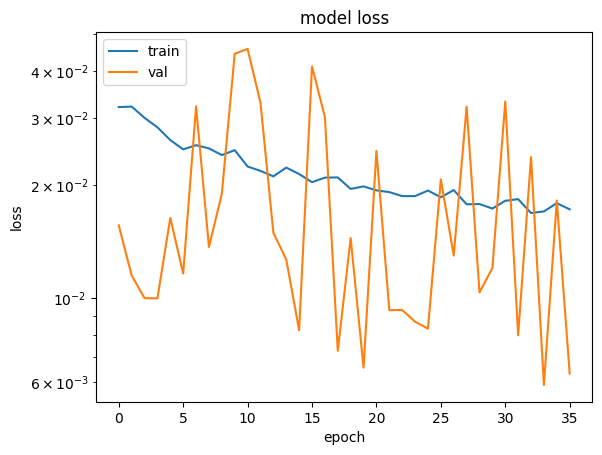

In [60]:
print(history.history.keys())
plt.semilogy(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
md2 = load_model(f"{model_path / prediction_filename}{ml_id}.keras")
weight_ml_point_save_path = Path('../data/processed/weight_ml_point') / ml_id
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    point_save_name = weight_ml_point_save_path / f"dl{file.stem}.pkl"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    tv_image = reduce_res_2darr(tv_image, 3)
    tv_image = np.expand_dims(tv_image, axis=3)
    
    prediction_cartesian = mdl2.predict(tv_image)
    # txt_file = (label_path / file.stem).with_suffix('.txt')
    # with open(txt_file, 'w') as f:
    #     for point in prediction_cartesian:
    #         f.write(f"{point},")
    # print(f"Saved {txt_file}")
    pickle.dump(prediction_cartesian, open(point_save_name, 'wb'))

ValueError: Argument(s) not recognized: {'jit_compile': True, 'is_legacy_optimizer': False}

# Save Video

## Linear Regression

In [18]:
tv = GetTV(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

# with open(f"{model_path / prediction_filename}.pkl", 'rb') as f:
#     model = pickle.load(f)
    
mp4_save_path = Path('../outputs/video/weighted_ml') / run_type
mp4_save_path.mkdir(parents=True, exist_ok=True)

In [23]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    mp4_save_name = mp4_save_path / f"{file.stem.split('_')[-1]}.mp4"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    inverted = tv.load(file, 'inverted')
    elevation = tv.load(file, 'elevation')[0]
    
    prediction_cartesian = model.predict(tv_image)
    
    prediction = get_index(prediction_cartesian, elevation, )
    labels = get_index(labels_cartesian, elevation)

    # Initialize figure and axes
    print("Animating...")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img = ax.imshow(inverted[0], origin='lower')
    hline_label = ax.axhline(labels[0], c='lime', label='label')
    hline_prediction = ax.axhline(prediction[0], c='red', label='prediction', ls='--')
    ax.legend(loc='upper right')
    ax.set_title(f'Inverted View: 0')

    fig.suptitle(f"Shot {file.stem.split('_')[-1]}")
    frames = []
    # Function to update the plot
    def update(idx):
        img.set_data(inverted[idx])
        
        hline_label.set_ydata([labels[idx]])
        hline_prediction.set_ydata([prediction[idx]])
        
        ax.set_title(f'Inverted View: {idx}')
        
        return img, hline_label, hline_prediction
        
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig, update, frames=range(inverted.shape[0]), blit=True, repeat=False)

    # Save the animation as an MP4 file
    print("Saving MP4...")
    FFwriter = animation.FFMpegWriter(fps=30, extra_args=["-vcodec", "libx264"])
    ani.save(mp4_save_name, writer=FFwriter)

    plt.close(fig)

Shot: 199354
Animating...
Saving MP4...


## Deep Learning

In [66]:
ml_id = ''
tv = GetTV(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

mdl2 = load_model(f"{model_path / prediction_filename}{ml_id}.keras")
    
mp4_save_path = Path('../outputs/video/weighted_dl') / run_type
mp4_save_path.mkdir(parents=True, exist_ok=True)

weight_ml_point_save_path = Path('../data/processed/weight_ml_point') / ml_id

Shot: 189057
Animating...
Saving MP4...


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

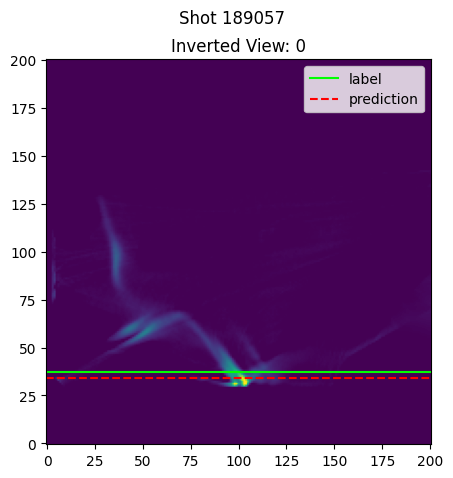

In [67]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    mp4_save_name = mp4_save_path / f"{file.stem.split('_')[-1]}.mp4"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    point_save_name = weight_ml_point_save_path / f"dl{file.stem}.pkl"
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    vid_input = np.expand_dims(tv_image, axis=3)
    inverted = tv.load(file, 'inverted')
    elevation = tv.load(file, 'elevation')[0]
    with open(point_save_name, 'rb') as f:
        prediction_cartesian = pickle.load(f)
    prediction = get_index(prediction_cartesian, elevation, )
    labels = get_index(labels_cartesian, elevation)

    # Initialize figure and axes
    print("Animating...")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img = ax.imshow(inverted[0], origin='lower')
    hline_label = ax.axhline(labels[0], c='lime', label='label')
    hline_prediction = ax.axhline(prediction[0], c='red', label='prediction', ls='--')
    ax.legend(loc='upper right')
    ax.set_title(f'Inverted View: 0')

    fig.suptitle(f"Shot {file.stem.split('_')[-1]}")
    frames = []
    # Function to update the plot
    def update(idx):
        img.set_data(inverted[idx])
        
        hline_label.set_ydata([labels[idx]])
        hline_prediction.set_ydata([prediction[idx]])
        
        ax.set_title(f'Inverted View: {idx}')
        
        return img, hline_label, hline_prediction
        
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig, update, frames=range(inverted.shape[0]), blit=True, repeat=False)

    # Save the animation as an MP4 file
    print("Saving MP4...")
    FFwriter = animation.FFMpegWriter(fps=30, extra_args=["-vcodec", "libx264"])
    ani.save(mp4_save_name, writer=FFwriter)

    plt.close(fig)